# Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
plt.style.use("ggplot")

# OpenCV Image Library
import cv2

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

## Loading Training Data + EDA

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/AML/Challenge1/dataset/train.csv")
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


The train data contains 17500 images which can be found in a seperate directory also we have a csv file but we can't directly visualize them as we'll see later.

The test data has 4000 images and it is stored in a seperate directory. Note that it doesn't have a csv file as we saw for the train data.

In [ ]:
# print(f"Train Size: {len(os.listdir('/content/drive/MyDrive/AML/Challenge1/dataset/train/train'))}")#Train Size: 17500
# print(f"Test Size: {len(os.listdir('/content/drive/MyDrive/AML/Challenge1/dataset/test/test'))}")#Test Size: 4000

Here we inspect the data to see the amount of training samples for each class. As we can see about 2/3 of the training data belongs to one class. If the dataset you are using contains almost or above 90% of the training data belonging to one single class then it will greatly impact your results. This is called skewed classes, we can use data augmentation, sampling and several ways to overcome this. However I don't believe that's a problem here as we have enough data for CNNs to get great results.

In [ ]:
# # Counting the number of sample data for each class
# value_counts = train_df.has_cactus.value_counts()
# %matplotlib inline
# plt.pie(value_counts, labels=['Has Cactus', 'No Cactus'], autopct='%1.1f', colors=['green', 'red'], shadow=True)
# plt.figure(figsize=(5,5))
# plt.show()

## Setting up Train Data for Pytorch
We cannot simply use the raw image data to make predictions using PyTorch. There are several pre-processing steps involved which we'll discuss in detail in this section.

**Step 1:**

First up we define a custom class that extends PyTorch's `torch.utils.data.Dataset` class. I think everything in there is pretty straight-forward. We define our constructors and add two different methods `len` and `getitem` which essentially replaces the parent definitions.  

In [ ]:
# Data paths
train_path = '/content/drive/MyDrive/AML/Challenge1/dataset/train/train/'
test_path = '/content/drive/MyDrive/AML/Challenge1/dataset/test/test/'

In [ ]:
# # Our own custom class for datasets
# class CreateDataset(Dataset):
#     def __init__(self, df_data, data_dir = './', transform=None):
#         super().__init__()
#         self.df = df_data.values
#         self.data_dir = data_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, index):
#         img_name,label = self.df[index]
#         img_path = os.path.join(self.data_dir, img_name)
#         image = cv2.imread(img_path)
#         if self.transform is not None:
#             image = self.transform(image)
#         return image, label

import os
import cv2
from torch.utils.data import Dataset

class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir='./', transform=None):
        super().__init__()
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Preload all images into memory
        for img_name, label in df_data.values:
            img_path = os.path.join(self.data_dir, img_name)
            image = cv2.imread(img_path)
            if self.transform is not None:
                image = self.transform(image)
            self.images.append(image)
            self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Fetch preloaded images and labels
        return self.images[index], self.labels[index]


**Step 2:**

Now that we've defined our class it is time to pass the raw data and convert it to PyTorch understandable form.

**Transforms** - We can use the transforms feature in PyTorch to apply Data Augmentations which help us improve the accuracy of our model when done right. There are sevaral transformations that can be applied for which you may want to have a look at the [documentation here](https://pytorch.org/docs/stable/torchvision/transforms.html). Here we conert it to a PIL image first. Random horizontal flipping of sample images is applied along with random rotation of 10 degrees for random training examples. We then convert the images into a PyTorch tensor then we normalize the them.

**Creating our Dataset -** We then use our `CreateDataset` class to covert the raw data in the way PyTorch expects. We have also applied the transformations there.

In [ ]:
# transforms_train = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(10),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])
# transforms_test = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

In [ ]:
from sklearn.model_selection import train_test_split

# # First split: separate out the training dataset
# train_df, temp_df = train_test_split(train_df, test_size=0.4, random_state=42, stratify=train_df['has_cactus'])

# # Second split: separate the temporary dataset into validation and test datasets
# valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['has_cactus'])

In [ ]:
#@title check_label_distribution
# def check_label_distribution(train_df, valid_df, test_df, label_column='has_cactus'):
#     """
#     Prints the distribution of labels in the training, validation, and test datasets.

#     Parameters:
#         train_df (pd.DataFrame): Training dataset.
#         valid_df (pd.DataFrame): Validation dataset.
#         test_df (pd.DataFrame): Testing dataset.
#         label_column (str): The name of the column containing the labels.
#     """
#     # Calculate and print the proportion of each label in the training set
#     train_dist = train_df[label_column].value_counts(normalize=True)
#     print("Training Set Label Distribution:")
#     print(train_dist)

#     # Calculate and print the proportion of each label in the validation set
#     valid_dist = valid_df[label_column].value_counts(normalize=True)
#     print("\nValidation Set Label Distribution:")
#     print(valid_dist)

#     # Calculate and print the proportion of each label in the test set
#     test_dist = test_df[label_column].value_counts(normalize=True)
#     print("\nTest Set Label Distribution:")
#     print(test_dist)

# # Use the function with your datasets
# check_label_distribution(train_df, valid_df, test_df)


In [ ]:
# train_data = CreateDataset(df_data=train_df, data_dir=train_path, transform=transforms_train)
# valid_data = CreateDataset(df_data=valid_df, data_dir=train_path,transform=transforms_test)
# test_data = CreateDataset(df_data=test_df, data_dir=train_path,transform=transforms_test)

In [ ]:
# import pickle
# # Define file paths
# train_data_path = '/content/drive/MyDrive/AML/Challenge1/train_data.pkl'
# valid_data_path = '/content/drive/MyDrive/AML/Challenge1/valid_data.pkl'
# test_data_path = '/content/drive/MyDrive/AML/Challenge1/test_data.pkl'

# # Function to save a dataset using pickle
# def save_dataset(dataset, file_path):
#     with open(file_path, 'wb') as file:
#         pickle.dump(dataset, file)

# # Save the datasets
# save_dataset(train_data, train_data_path)
# save_dataset(valid_data, valid_data_path)
# save_dataset(test_data, test_data_path)

In [ ]:
import pickle

train_data_path = '/content/drive/MyDrive/AML/Challenge1/train_data_augmented.pkl'
valid_data_path = '/content/drive/MyDrive/AML/Challenge1/valid_data_augmented.pkl'
test_data_path = '/content/drive/MyDrive/AML/Challenge1/test_data_augmented.pkl'
# Function to load a dataset using pickle
def load_dataset(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

# Load the datasets
train_data = load_dataset(train_data_path)
valid_data = load_dataset(valid_data_path)
test_data = load_dataset(test_data_path)


**Step 3:**

Batch size is set. The batch size is usually set between 64 and 256. The batch size does have an effect on the final test accuracy. One way to think about it is that smaller batches means that the number of parameter updates per epoch is greater.

Then the percentage of data needed for validation is set to 20%, which almost always seem to work for me. But in the end it's just another hyperparameter you can tune.

In the next steps we use the `torch.utils.data.samplerSubsetRandomSampler` function to split our data into training and validation sets, which is similar to `train_test_split` fuction of scikit-learn.

We have the training data passed into the trainloader. We can make an iterator with iter(trainloader) that can help us grab data. Later, we'll use this to loop through the dataset for training. Each time we can pull out data of the size of the batch_size defined.

In [ ]:
# Set Batch Size
batch_size = 64

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(valid_data, batch_size=batch_size,shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size,shuffle=False)

## Setting up Test Data
This section of code should make sense to you now. The same steps used above are repeated for the test data as well.

Note that we don't augment our data on the training set. This is because augmentation is only done on the training set to improve the performance by giving our model complex variations that might make it generalize well to new samples on the test set, so it doesn't make sense to do data augmentation on the test data as well. However we still need to convert it to a tensor and normalize it.

In [ ]:
# transforms_test = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # creating test data
# sample_sub = pd.read_csv("/content/drive/MyDrive/AML/Challenge1/dataset/sample_submission.csv")
# test_data = CreateDataset(df_data=sample_sub, data_dir=test_path, transform=transforms_test)

# # prepare the test loader
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Visualize Images

Visualizing the images and inspecting them to get a better idea of what they are is always helpful before going on the construct our model to make predictions.

We can see aerial images of cactus. The images contain color channels, we should keep in mind and they are 32x32 images. Note that these images are very low  inresolution yet as humans we have evolved in such a way to make sense of even these kind of pictures. We're going to build a CNN in the next few sections to ultimately achieve just that or even better performance.

In [ ]:
classes = [ 'No Cactus','Cactus']

In [ ]:
def imshow(img):
    '''Helper function to un-normalize and display an image'''
    # unnormalize
    img = img / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))

In [ ]:
# # obtain one batch of training images
# dataiter = iter(train_loader)
# images, labels = next(dataiter)
# images = images.numpy() # convert images to numpy for display

# # plot the images in the batch, along with the corresponding labels
# fig = plt.figure(figsize=(25, 4))
# # display 20 images
# for idx in np.arange(20):
#     ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
#     imshow(images[idx])
#     ax.set_title(classes[labels[idx]])

## Viewing an Image in More Detail
Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images for illustration purposes. This helps me explain CNNs later.

Each little square you can see are pixels with their normalized values. Larger value means brighter, lower means darker. This is how images are represented in our computers. When we combine all three channels we get a color image. This RGB color scheme can represent about 16.77 million colors, which is awesome.

As you might have guessed already color images are actually three dimensional, where Greyscale images for example are 1D.

In [ ]:
#@title Not interesting
# rgb_img = np.squeeze(images[3])
# channels = ['red channel', 'green channel', 'blue channel']

# fig = plt.figure(figsize = (36, 36))
# for idx in np.arange(rgb_img.shape[0]):
#     ax = fig.add_subplot(3, 1, idx + 1)
#     img = rgb_img[idx]
#     ax.imshow(img, cmap='gray')
#     ax.set_title(channels[idx])
#     width, height = img.shape
#     thresh = img.max()/2.5
#     for x in range(width):
#         for y in range(height):
#             val = round(img[x][y],2) if img[x][y] !=0 else 0
#             ax.annotate(str(val), xy=(y,x),
#                     horizontalalignment='center',
#                     verticalalignment='center', size=8,
#                     color='white' if img[x][y]<thresh else 'black')

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.2)
        self.batch_norm1 = nn.BatchNorm1d(512)

    def forward(self, x):
        # print(f"x : {x.shape}")
        x = F.relu(self.conv1(x))
        # print(f"x = F.relu(self.conv1(x)): {x.shape}")
        x = self.pool(F.relu(self.conv2(x)))
        # print(f"x = self.pool(F.relu(self.conv2(x))) :{x.shape}")
        x = F.relu(self.conv3(x))
        # print(f"x = F.relu(self.conv3(x)): {x.shape}")
        x = self.pool(F.relu(self.conv4(x)))
        # print(f"x = self.pool(F.relu(self.conv4(x))): {x.shape}")
        # flatten image input
        x = x.view(-1, 32 * 6 * 6)
        # print(f"x = self.flatten(x) : {x.shape}")
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.batch_norm1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
# create a complete CNN
model = CNN()
print(model)

# Move model to GPU if available
if train_on_gpu: model.to("cuda")

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


## Training our CNN

Now the training steps are same as that of training an MLP which I explained in a previous kernel. The only difference here is that I'm saving the model everytime the validation loss decreases. Finally we'll get the best model params learned. This is one type of early stopping.

In [ ]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adamax(model.parameters(), lr=0.001)

In [ ]:
# number of epochs to train the model
n_epochs = 80

valid_loss_min = np.Inf  # track change in validation loss

# keeping track of losses as it happen
train_losses = []
valid_losses = []

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.to("cuda"), target.to("cuda")

        # clear the gradients of all optimized variables
        optimizer.zero_grad()

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # calculate the batch loss
        loss = criterion(output, target)

        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # perform a single optimization step (parameter update)
        optimizer.step()

        # update training loss
        train_loss += loss.item()

        # Print log information every specified number of batches
        if (batch_idx + 1) % 10 == 0:  # Adjust print frequency depending on your preference
            print(f'Epoch {epoch}, Batch {batch_idx + 1}: Training Loss: {loss.item()}')

    ######################
    # validate the model #
    ######################
    model.eval()
    with torch.no_grad():  # to speed up validation
        for data, target in valid_loader:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.to("cuda"), target.to("cuda")

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # calculate the batch loss
            loss = criterion(output, target)

            # update average validation loss
            valid_loss += loss.item()

    # calculate average losses
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss < valid_loss_min and abs(valid_loss_min-valid_loss)>0.01:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
            valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss


Epoch 1, Batch 10: Training Loss: 0.4017717242240906
Epoch 1, Batch 20: Training Loss: 0.2940725088119507
Epoch 1, Batch 30: Training Loss: 0.23585116863250732
Epoch 1, Batch 40: Training Loss: 0.21254794299602509
Epoch 1, Batch 50: Training Loss: 0.20977915823459625
Epoch 1, Batch 60: Training Loss: 0.23790526390075684
Epoch 1, Batch 70: Training Loss: 0.08109036833047867
Epoch 1, Batch 80: Training Loss: 0.1983666718006134
Epoch 1, Batch 90: Training Loss: 0.25350409746170044
Epoch 1, Batch 100: Training Loss: 0.13197283446788788
Epoch 1, Batch 110: Training Loss: 0.09354786574840546
Epoch 1, Batch 120: Training Loss: 0.11242397874593735
Epoch 1, Batch 130: Training Loss: 0.17472238838672638
Epoch 1, Batch 140: Training Loss: 0.10842884331941605
Epoch 1, Batch 150: Training Loss: 0.09707751125097275
Epoch 1, Batch 160: Training Loss: 0.13929004967212677
Epoch 1, Batch 170: Training Loss: 0.11339803785085678
Epoch 1, Batch 180: Training Loss: 0.11765524744987488
Epoch 1, Batch 190: Tr

## Performance Graph
I told you how powerful CNNs are now look at that graph. We've achieved state of the art results as promised.

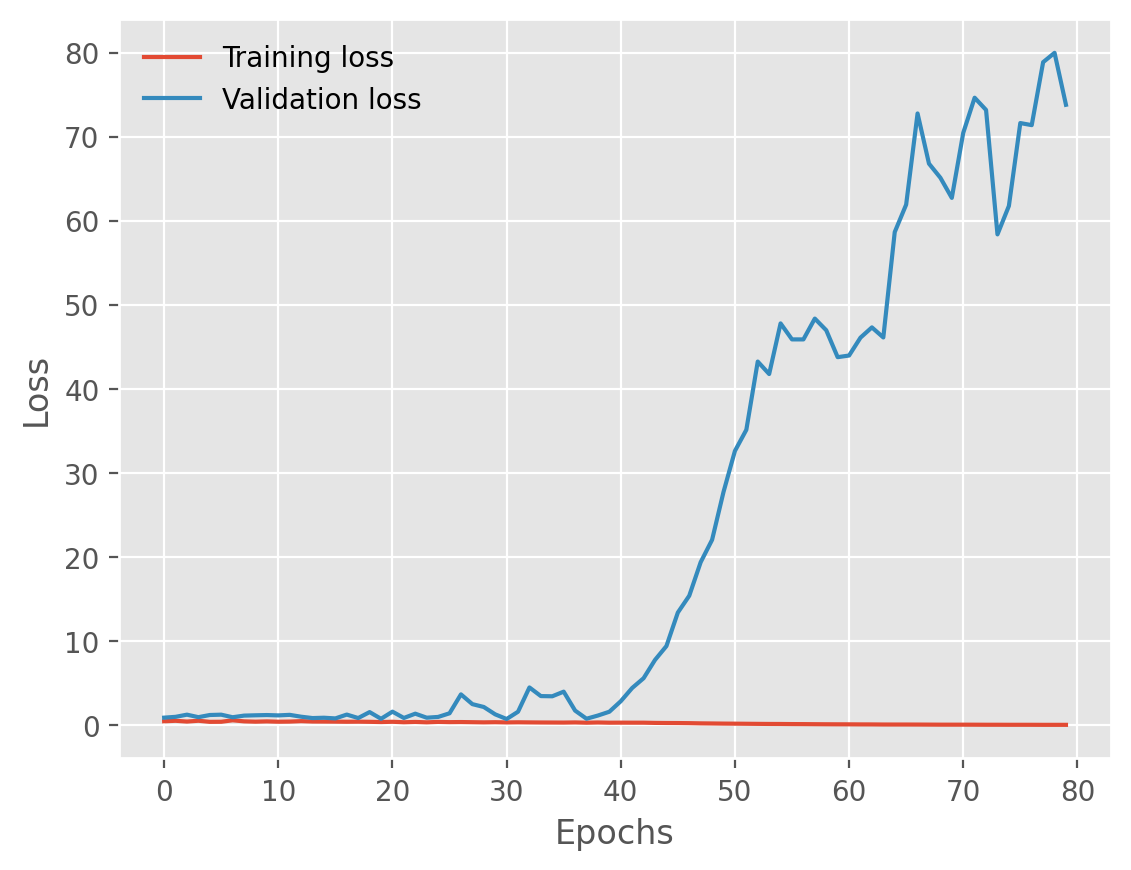

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [ ]:
# Load Best parameters learned from training into our model to make predictions later
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

## Make Predictions on Test Set

In [ ]:
#@title Kaagle predcitions
# Turn off gradients
# model.eval()

# preds = []
# for batch_i, (data, target) in enumerate(test_loader):
#     data, target = data.to("cuda"), target.to("cuda")
#     output = model(data)

#     pr = output[:,1].detach().cpu().numpy()
#     for i in pr:
#         preds.append(i)

# # Create Submission file
# sample_sub['has_cactus'] = preds
# sample_sub.to_csv('submission.csv', index=False)

In [ ]:
import torch
import pandas as pd

# Ensure the model is in evaluation mode
model.eval()

predictions_test = []
ground_truths_test = []
predictions_valid = []
ground_truths_valid = []

# Loop over the test data loader
for data, target in test_loader:
    if train_on_gpu:
      data = data.to("cuda")
      target = target.to("cuda")

    # Forward pass to get output/logits
    outputs = model(data)

    # Apply softmax to convert logits to probabilities
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Get the predicted class (the one with higher probability)
    predicted_classes = probabilities[:, 1].detach().cpu().numpy()  # Probabilities of being class '1'

    # Store predictions and ground truth
    predictions_test.extend(predicted_classes)
    ground_truths_test.extend(target.cpu().numpy())

# Create a DataFrame to store predictions and ground truths
df_test = pd.DataFrame({
    'Predicted Probability': predictions_test,
    'Ground Truth': ground_truths_test
})


# Loop over the validation data loader
for data, target in valid_loader:
    if train_on_gpu:
      data = data.to("cuda")
      target = target.to("cuda")

    # Forward pass to get output/logits
    outputs = model(data)

    # Apply softmax to convert logits to probabilities
    probabilities = torch.nn.functional.softmax(outputs, dim=1)

    # Get the predicted class (the one with higher probability)
    predicted_classes = probabilities[:, 1].detach().cpu().numpy()  # Probabilities of being class '1'

    # Store predictions and ground truth
    predictions_valid.extend(predicted_classes)
    ground_truths_valid.extend(target.cpu().numpy())

# Create a DataFrame to store predictions and ground truths
df_valid = pd.DataFrame({
    'Predicted Probability': predictions_valid,
    'Ground Truth': ground_truths_valid
})


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Convert probabilities to class predictions using a threshold of 0.5
class_predictions_test = (np.array(predictions_test) > 0.5).astype(int)
class_predictions_valid = (np.array(predictions_valid) > 0.5).astype(int)
# Ground truths and predictions must be NumPy arrays
ground_truths_test = np.array(ground_truths_test)
ground_truths_valid = np.array(ground_truths_valid)

# Calculate metrics
accuracy_valid = accuracy_score(ground_truths_valid, class_predictions_valid)
recall_valid = recall_score(ground_truths_valid, class_predictions_valid)
f1_valid = f1_score(ground_truths_valid, class_predictions_valid)

accuracy_test = accuracy_score(ground_truths_test, class_predictions_test)
recall_test = recall_score(ground_truths_test, class_predictions_test)
f1_test = f1_score(ground_truths_test, class_predictions_test)

print(f"Validation Accuracy: {accuracy_valid}, Test Accuracy: {accuracy_test}")
print(f"Validation Recall: {recall_valid}, Test Recall: {recall_test}")
print(f"Validation F1 Score: {f1_valid}, Test F1 Score: {f1_test}")

Validation Accuracy: 0.652952380952381, Test Accuracy: 0.6655238095238095
Validation Recall: 0.5377980720446474, Test Recall: 0.5543147208121827
Validation F1 Score: 0.6994391290003299, Test F1 Score: 0.713259307642064


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Convert probabilities to class predictions using a threshold of 0.5
class_predictions_test = (np.array(predictions_test) > 0.5).astype(int)
class_predictions_valid = (np.array(predictions_valid) > 0.5).astype(int)
# Ground truths and predictions must be NumPy arrays
ground_truths_test = np.array(ground_truths_test)
ground_truths_valid = np.array(ground_truths_valid)

# Calculate metrics
accuracy_valid = accuracy_score(ground_truths_valid, class_predictions_valid)
recall_valid = recall_score(ground_truths_valid, class_predictions_valid)
f1_valid = f1_score(ground_truths_valid, class_predictions_valid)

accuracy_test = accuracy_score(ground_truths_test, class_predictions_test)
recall_test = recall_score(ground_truths_test, class_predictions_test)
f1_test = f1_score(ground_truths_test, class_predictions_test)

print(f"Validation Accuracy: {accuracy_valid}, Test Accuracy: {accuracy_test}")
print(f"Validation Recall: {recall_valid}, Test Recall: {recall_test}")
print(f"Validation F1 Score: {f1_valid}, Test F1 Score: {f1_test}")

Validation Accuracy: 0.9861904761904762, Test Accuracy: 0.9838095238095238
Validation Recall: 0.9911223842739378, Test Recall: 0.991751269035533
Validation F1 Score: 0.9908082408874802, Test F1 Score: 0.989240506329114


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Convert probabilities to class predictions using a threshold of 0.5
class_predictions_test = (np.array(predictions_test) > 0.5).astype(int)
class_predictions_valid = (np.array(predictions_valid) > 0.5).astype(int)
# Ground truths and predictions must be NumPy arrays
ground_truths_test = np.array(ground_truths_test)
ground_truths_valid = np.array(ground_truths_valid)

# Calculate metrics
accuracy_valid = accuracy_score(ground_truths_valid, class_predictions_valid)
recall_valid = recall_score(ground_truths_valid, class_predictions_valid)
f1_valid = f1_score(ground_truths_valid, class_predictions_valid)

accuracy_test = accuracy_score(ground_truths_test, class_predictions_test)
recall_test = recall_score(ground_truths_test, class_predictions_test)
f1_test = f1_score(ground_truths_test, class_predictions_test)

print(f"Validation Accuracy: {accuracy_valid}, Test Accuracy: {accuracy_test}")
print(f"Validation Recall: {recall_valid}, Test Recall: {recall_test}")
print(f"Validation F1 Score: {f1_valid}, Test F1 Score: {f1_test}")

Validation Accuracy: 0.9861904761904762, Test Accuracy: 0.9914285714285714
Validation Recall: 0.9879518072289156, Test Recall: 0.9961928934010152
Validation F1 Score: 0.9907790143084261, Test F1 Score: 0.9943001899936669


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Convert probabilities to class predictions using a threshold of 0.5
class_predictions_test = (np.array(predictions_test) > 0.5).astype(int)
class_predictions_valid = (np.array(predictions_valid) > 0.5).astype(int)
# Ground truths and predictions must be NumPy arrays
ground_truths_test = np.array(ground_truths_test)
ground_truths_valid = np.array(ground_truths_valid)

# Calculate metrics
accuracy_valid = accuracy_score(ground_truths_valid, class_predictions_valid)
recall_valid = recall_score(ground_truths_valid, class_predictions_valid)
f1_valid = f1_score(ground_truths_valid, class_predictions_valid)

accuracy_test = accuracy_score(ground_truths_test, class_predictions_test)
recall_test = recall_score(ground_truths_test, class_predictions_test)
f1_test = f1_score(ground_truths_test, class_predictions_test)

print(f"Validation Accuracy: {accuracy_valid}, Test Accuracy: {accuracy_test}")
print(f"Validation Recall: {recall_valid}, Test Recall: {recall_test}")
print(f"Validation F1 Score: {f1_valid}, Test F1 Score: {f1_test}")


Validation Accuracy: 0.9804761904761905, Test Accuracy: 0.9857142857142858
Validation Recall: 0.9866835764109068, Test Recall: 0.991751269035533
Validation F1 Score: 0.9869965112591182, Test F1 Score: 0.9904942965779467


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ground_truths_test, class_predictions_test))

              precision    recall  f1-score   support

           0       0.43      1.00      0.60       655
           1       1.00      0.55      0.71      1970

    accuracy                           0.67      2625
   macro avg       0.71      0.78      0.66      2625
weighted avg       0.86      0.67      0.68      2625



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ground_truths_test, class_predictions_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       655
           1       0.99      0.99      0.99      1970

    accuracy                           0.99      2625
   macro avg       0.99      0.98      0.99      2625
weighted avg       0.99      0.99      0.99      2625



In [ ]:
from sklearn.metrics import matthews_corrcoef

mcc_valid = matthews_corrcoef(ground_truths_valid, class_predictions_valid)
mcc_test = matthews_corrcoef(ground_truths_test, class_predictions_test)
print(f"Matthews Correlation Coefficient:  Validation {mcc_valid}, Test {mcc_test}")

Matthews Correlation Coefficient:  Validation 0.9630578373493975, Test 0.9565990404444403


In [ ]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_valid = balanced_accuracy_score(ground_truths_valid, class_predictions_valid)
balanced_accuracy_test = balanced_accuracy_score(ground_truths_test, class_predictions_test)

print(f"Balanced Accuracy: Valid {balanced_accuracy_valid}, Test {balanced_accuracy_test}")

Balanced Accuracy: Valid 0.9824987784488057, Test 0.9821971751850274


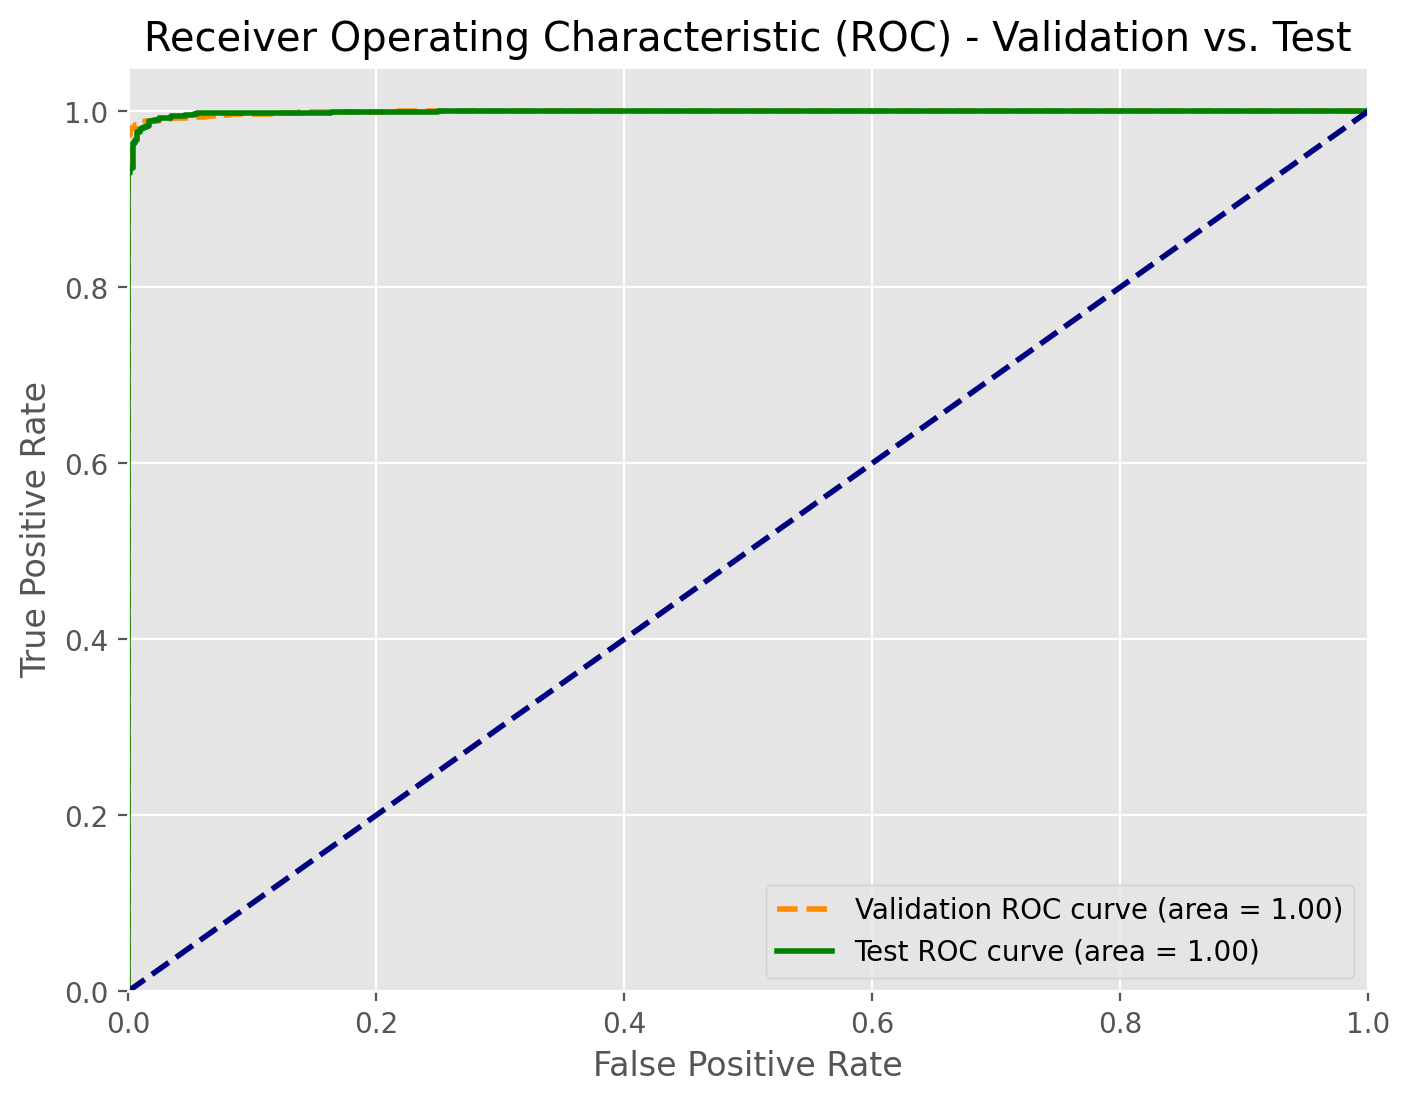

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve for validation data
fpr_valid, tpr_valid, _ = roc_curve(ground_truths_valid, predictions_valid)
roc_auc_valid = auc(fpr_valid, tpr_valid)

# Calculate ROC curve for test data
fpr_test, tpr_test, _ = roc_curve(ground_truths_test, predictions_test)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_valid, tpr_valid, color='darkorange', lw=2, linestyle='--',
         label=f'Validation ROC curve (area = {roc_auc_valid:.2f})')
plt.plot(fpr_test, tpr_test, color='green', lw=2,
         label=f'Test ROC curve (area = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Validation vs. Test')
plt.legend(loc="lower right")
plt.show()


### **If you like this kernel or wish to fork it please give it an UPVOTE to show your appreciation.**

**Authored By:**

[Abhinand](https://www.kaggle.com/abhinand05)